In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [23]:
df=pd.read_csv("lyrics-data.csv")
df_genres = pd.read_csv("artists-genres.csv")
df

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [24]:
df.describe()

,ALink,SName,SLink,Lyric,language
count,379930,379928,379930,379854,365296
unique,4238,267258,379892,371181,52
top,/anjos-anonimos/,Intro,/joan-baez/aint-gonna-let-nobody-turn-me-aroun...,Instrumental,en
freq,1029,116,2,2087,191814


In [25]:
df.ALink.value_counts()

/anjos-anonimos/            1029
/carlos-santorelli/          903
/frank-sinatra/              828
/matheus-hardke/             797
/marchinhas-de-carnaval/     782
                            ... 
/cl-a-posse/                   1
/ukulele-das-americas/         1
/clara-fallandes/              1
/the-sopranos/                 1
/avoure/                       1
Name: ALink, Length: 4238, dtype: int64

In [26]:
df.language.value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

In [27]:
df = df[df['language'] == 'en']

In [28]:
df.describe()

,ALink,SName,SLink,Lyric,language
count,191814,191812,191814,191814,191814
unique,2508,138182,191793,189394,1
top,/frank-sinatra/,Home,/nat-king-cole/i-love-you-for-sentimental-reas...,Shortcut to part of Bill Monroe Lyrics\nBill M...,en
freq,819,93,2,41,191814


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191814 entries, 69 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     191814 non-null  object
 1   SName     191812 non-null  object
 2   SLink     191814 non-null  object
 3   Lyric     191814 non-null  object
 4   language  191814 non-null  object
dtypes: object(5)
memory usage: 8.8+ MB


In [30]:
df_genres.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [31]:
df_genres.rename(columns={'Link': 'ALink'}, inplace=True)

In [32]:
df = df.merge(df_genres[["ALink","Genres"]], on="ALink", how="left")

In [33]:
df['Genres'].str.split(';', expand=True)

,0,1,2,3
0,Pop,Axé,Romântico,None
1,Pop,Axé,Romântico,None
2,Pop,Axé,Romântico,None
3,Pop,Axé,Romântico,None
4,Pop,Axé,Romântico,None
...,...,...,...,...
191809,World Music,Gospel/Religioso,None,None
191810,World Music,Gospel/Religioso,None,None
191811,World Music,Gospel/Religioso,None,None
191812,World Music,Gospel/Religioso,None,None


In [34]:
df[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4']] = df['Genres'].str.split(';', expand=True)

In [35]:
df

,ALink,SName,SLink,Lyric,language,Genres,Genre 1,Genre 2,Genre 3,Genre 4
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,Pop; Axé; Romântico,Pop,Axé,Romântico,None
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,Pop; Axé; Romântico,Pop,Axé,Romântico,None
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,Pop; Axé; Romântico,Pop,Axé,Romântico,None
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,Pop; Axé; Romântico,Pop,Axé,Romântico,None
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,Pop; Axé; Romântico,Pop,Axé,Romântico,None
...,...,...,...,...,...,...,...,...,...,...
191809,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en,World Music; Gospel/Religioso,World Music,Gospel/Religioso,None,None
191810,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en,World Music; Gospel/Religioso,World Music,Gospel/Religioso,None,None
191811,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en,World Music; Gospel/Religioso,World Music,Gospel/Religioso,None,None
191812,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en,World Music; Gospel/Religioso,World Music,Gospel/Religioso,None,None


In [36]:
df = df.drop(columns=['Genres'])

In [37]:
df

,ALink,SName,SLink,Lyric,language,Genre 1,Genre 2,Genre 3,Genre 4
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,Pop,Axé,Romântico,None
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,Pop,Axé,Romântico,None
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,Pop,Axé,Romântico,None
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,Pop,Axé,Romântico,None
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,Pop,Axé,Romântico,None
...,...,...,...,...,...,...,...,...,...
191809,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en,World Music,Gospel/Religioso,None,None
191810,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en,World Music,Gospel/Religioso,None,None
191811,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en,World Music,Gospel/Religioso,None,None
191812,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en,World Music,Gospel/Religioso,None,None


In [38]:
df[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4']].apply(pd.Series.value_counts)

,Genre 1,Genre 2,Genre 3,Genre 4
Axé,NaN,712.0,894.0,NaN
Black Music,NaN,5133.0,6272.0,NaN
Blues,NaN,2020.0,2036.0,NaN
Bossa Nova,NaN,123.0,138.0,NaN
Chillout,NaN,346.0,400.0,NaN
...,...,...,...,...
Trap,99.0,NaN,NaN,NaN
Trilha Sonora,3112.0,NaN,NaN,NaN
Trip-Hop,1059.0,NaN,NaN,NaN
Tropical House,165.0,NaN,NaN,NaN


In [39]:
for col in df.columns:
    display(df[col].value_counts().head(10))

/frank-sinatra/      819
/elvis-presley/      747
/dolly-parton/       723
/matheus-hardke/     707
/lil-wayne/          689
/glee/               687
/hillsong-united/    646
/elton-john/         638
/temas-de-filmes/    628
/chris-brown/        623
Name: ALink, dtype: int64

Home               93
Silent Night       86
Intro              80
Forever            77
Stay               72
Tonight            68
White Christmas    67
Smile              67
Without You        65
Angel              65
Name: SName, dtype: int64

/nat-king-cole/i-love-you-for-sentimental-reasons.html        2
/biz-markie/im-an-ugly-nigga-so-what.html                     2
/duran-duran/im-looking-for-cracks-in-the-pavement.html       2
/mobb-deep/hey-luv-anything.html                              2
/chris-isaak/cant-do-a-thing-to-stop-me.html                  2
/cher/this-is-a-song-for-the-lonely.html                      2
/roxette/i-could-never-give-you-up.html                       2
/roger-waters/4-56-am-for-the-first-time-today-part-1.html    2
/roy-orbison/i-get-so-sentimental.html                        2
/motorhead/dont-need-religion.html                            2
Name: SLink, dtype: int64

Shortcut to part of Bill Monroe Lyrics\nBill Monroe - Evening Prayer Blues Lyrics\nBill Monroe - Fair Play Lyrics\nBill Monroe - Farther Along Lyrics\nBill Monroe - Feudin' Banjos Lyrics\nBill Monroe - Fire On The Mountain Lyrics\nBill Monroe - Flowers Of Love Lyrics\nBill Monroe - Foggy Mountain Top Lyrics\nBill Monroe - Foggy River Lyrics\nBill Monroe - Footprints In The Snow Lyrics\nBill Monroe - Four Walls Lyrics\nBill Monroe - Free Born Man Lyrics\nBill Monroe - Get Down On Your Knees And Pray Lyrics\nBill Monroe - Get Up John Lyrics\nBill Monroe - Girl In The Blue Velvet Band Lyrics\nBill Monroe - Give Me Wings Lyrics\nBill Monroe - Go Hither to Go Yonder Lyrics\nBill Monroe - Going Home Lyrics\nBill Monroe - Going Up Caney Lyrics\nBill Monroe - Goodbye Old Pal Lyrics\nBill Monroe - Gotta Travel On Lyrics\nBill Monroe - Grey Eagle Lyrics\nBill Monroe - Hallelujah I'm Ready Lyrics\nBill Monroe - Happy On My Way Lyrics\nBill Monroe - Harbor Of Love Lyrics\nBill Monroe - Have A Feas

en    191814
Name: language, dtype: int64

Rock                25177
Pop                 13759
Heavy Metal         13496
Indie               12998
Rap                  9589
Pop/Rock             9019
Hip Hop              8412
Country              7377
Rock Alternativo     5555
R&B                  5309
Name: Genre 1, dtype: int64

 Rock           23493
 Pop            12173
 Pop/Rock        9114
 Hip Hop         8664
 Hard Rock       7842
 Romântico       7796
 R&B             7317
 Folk            5435
 Rap             5355
 Black Music     5133
Name: Genre 2, dtype: int64

 Rock                15036
 Pop/Rock             8135
 Pop                  7639
 Romântico            6471
 Black Music          6272
 Hard Rock            4776
 Rock Alternativo     4160
 Hip Hop              3826
 Dance                3709
 Heavy Metal          3580
Name: Genre 3, dtype: int64

 Instrumental    628
 Clássico        317
 Pop/Rock         92
 Tecnopop         31
 Rock             11
Name: Genre 4, dtype: int64

In [40]:
df['Genre 1'] = df['Genre 1'].str.strip()
df['Genre 2'] = df['Genre 2'].str.strip()
df['Genre 3'] = df['Genre 3'].str.strip()
df['Genre 4'] = df['Genre 4'].str.strip()

In [41]:
from collections import Counter

df_genres = df[['Genre 1','Genre 2','Genre 3', 'Genre 4']]

final_count = Counter()
for col in df_genres.columns:
    final_count = Counter(df_genres[col]) + final_count

print(final_count)

Counter({None: 322215, 'Rock': 63717, 'Pop': 33571, 'Pop/Rock': 26360, 'Heavy Metal': 21759, 'Hip Hop': 20902, 'Indie': 20134, 'Romântico': 17947, 'Hard Rock': 17250, 'Rap': 17114, 'R&B': 15581, 'Rock Alternativo': 13061, 'Black Music': 13024, 'Dance': 11895, 'Folk': 11124, 'Country': 10630, 'Punk Rock': 9215, 'Soul Music': 8131, 'Electronica': 7799, 'Gospel/Religioso': 7337, 'Hardcore': 7082, 'Trilha Sonora': 6213, 'Blues': 6094, 'Gótico': 4984, 'Soft Rock': 4483, 'Progressivo': 4365, 'Jazz': 4343, 'Tecnopop': 3873, 'Pós-Punk': 3274, 'Reggae': 3207, 'Rockabilly': 3100, 'New Wave': 3075, 'Pop/Punk': 3039, 'Disco': 2890, 'Grunge': 2752, 'Funk': 2454, 'Psicodelia': 2258, 'Clássico': 2170, 'Instrumental': 1909, 'Surf Music': 1901, 'House': 1785, nan: 1744, 'Emocore': 1689, 'Axé': 1620, 'Classic Rock': 1533, 'COLETÂNEA': 1392, 'J-Pop/J-Rock': 1230, 'Infantil': 1220, 'Trip-Hop': 1203, 'Ska': 1200, 'New Age': 1117, 'Industrial': 1004, 'Chillout': 974, 'Piano Rock': 965, 'Power-Pop': 917, 'MP

In [49]:
df = df[(df['Genre 1'] == 'Rock') | (df['Genre 2'] == 'Rock') | (df['Genre 3'] == 'Rock') | (df['Genre 4'] == 'Rock')]

In [50]:
df

,ALink,SName,SLink,Lyric,language,Genre 1,Genre 2,Genre 3,Genre 4
10749,/elvis-presley/,Can't Help Falling In Love,/elvis-presley/cant-help-falling-in-love.html,"Wise men say, only fools rush in\nBut I can't ...",en,Rockabilly,Romântico,Rock,None
10750,/elvis-presley/,Suspicious Minds,/elvis-presley/suspicious-minds.html,We're caught in a trap\nI can't walk out\nBeca...,en,Rockabilly,Romântico,Rock,None
10751,/elvis-presley/,Always On My Mind,/elvis-presley/always-on-my-mind.html,"Maybe I didn't treat you,\nQuite as good as I ...",en,Rockabilly,Romântico,Rock,None
10752,/elvis-presley/,Love Me Tender,/elvis-presley/love-me-tender.html,"Love me tender, love me sweet,\nNever let me g...",en,Rockabilly,Romântico,Rock,None
10753,/elvis-presley/,My Way,/elvis-presley/my-way.html,And now the end is near\nAnd so I face the fin...,en,Rockabilly,Romântico,Rock,None
...,...,...,...,...,...,...,...,...,...
191186,/club-penguin/,Party in my Iggy,/club-penguin/party-in-my-iggy.html,I wonder what's that funky sound\nfrom around ...,en,Trilha Sonora,Rock,K-Pop/K-Rock,None
191187,/club-penguin/,The Party Starts Now,/club-penguin/the-party-starts-now.html,Get up Party Penguins come on haven't you hear...,en,Trilha Sonora,Rock,K-Pop/K-Rock,None
191188,/club-penguin/,We Are the Penguins - Dj Cadence,/club-penguin/we-are-the-penguins-dj-cadence.html,Check one\nTurn the volume up\nAnd join the cl...,en,Trilha Sonora,Rock,K-Pop/K-Rock,None
191189,/club-penguin/,You Gotta Have Wigman (Puffle Party),/club-penguin/you-gotta-have-wigman-puffle-par...,"Puffle party, party, party, party, party\n\nWe...",en,Trilha Sonora,Rock,K-Pop/K-Rock,None


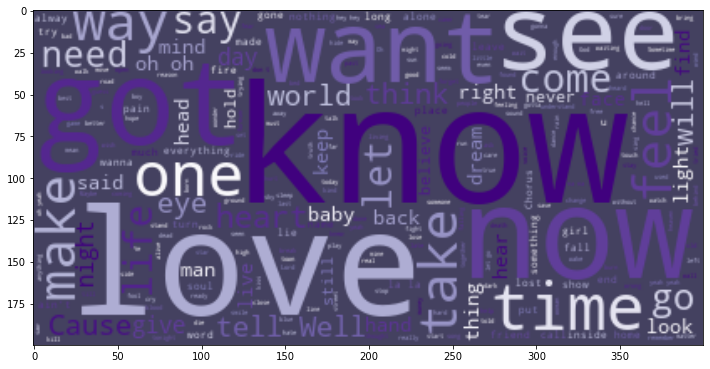

In [52]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(df["Lyric"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [53]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

C:\Users\jorpe\AppData\Local\Temp/ipykernel_15456/4236211263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))


,ALink,SName,SLink,Lyric,language,Genre 1,Genre 2,Genre 3,Genre 4,Number_of_words
10749,/elvis-presley/,Can't Help Falling In Love,/elvis-presley/cant-help-falling-in-love.html,"Wise men say, only fools rush in\nBut I can't ...",en,Rockabilly,Romântico,Rock,None,110
10750,/elvis-presley/,Suspicious Minds,/elvis-presley/suspicious-minds.html,We're caught in a trap\nI can't walk out\nBeca...,en,Rockabilly,Romântico,Rock,None,203
10751,/elvis-presley/,Always On My Mind,/elvis-presley/always-on-my-mind.html,"Maybe I didn't treat you,\nQuite as good as I ...",en,Rockabilly,Romântico,Rock,None,159
10752,/elvis-presley/,Love Me Tender,/elvis-presley/love-me-tender.html,"Love me tender, love me sweet,\nNever let me g...",en,Rockabilly,Romântico,Rock,None,125
10753,/elvis-presley/,My Way,/elvis-presley/my-way.html,And now the end is near\nAnd so I face the fin...,en,Rockabilly,Romântico,Rock,None,249
